Cleaning corrupted images...
Cleanup complete.
Found 3267 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.8419 - loss: 0.4219 - val_accuracy: 0.7194 - val_loss: 0.5734
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8847 - loss: 0.2982 - val_accuracy: 0.7377 - val_loss: 0.6115
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9066 - loss: 0.2400 - val_accuracy: 0.6691 - val_loss: 0.8137
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9239 - loss: 0.2209 - val_accuracy: 0.6752 - val_loss: 0.8959
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9283 - loss: 0.2100 - val_accuracy: 0.6654 - val_loss: 0.8520


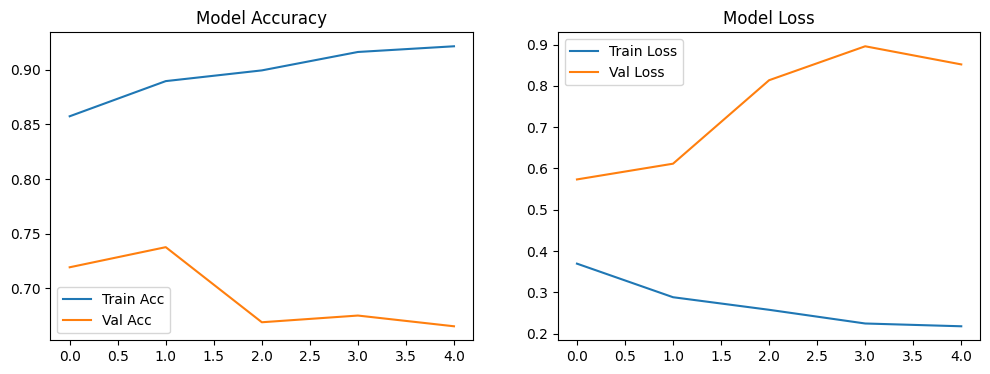

26/26 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

Classification Report:

               precision    recall  f1-score   support

    Fractured       0.25      0.45      0.32       143
Non_fractured       0.86      0.71      0.78       673

     accuracy                           0.67       816
    macro avg       0.55      0.58      0.55       816
 weighted avg       0.75      0.67      0.70       816



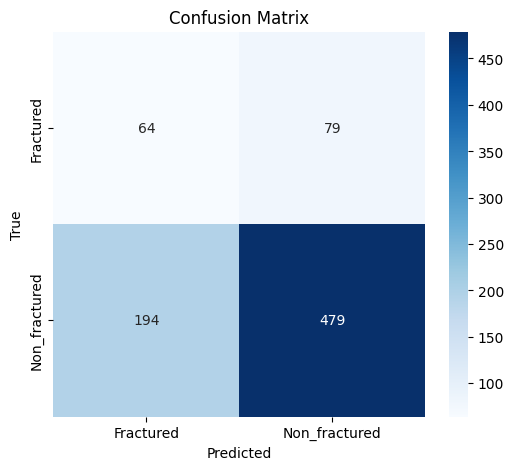

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


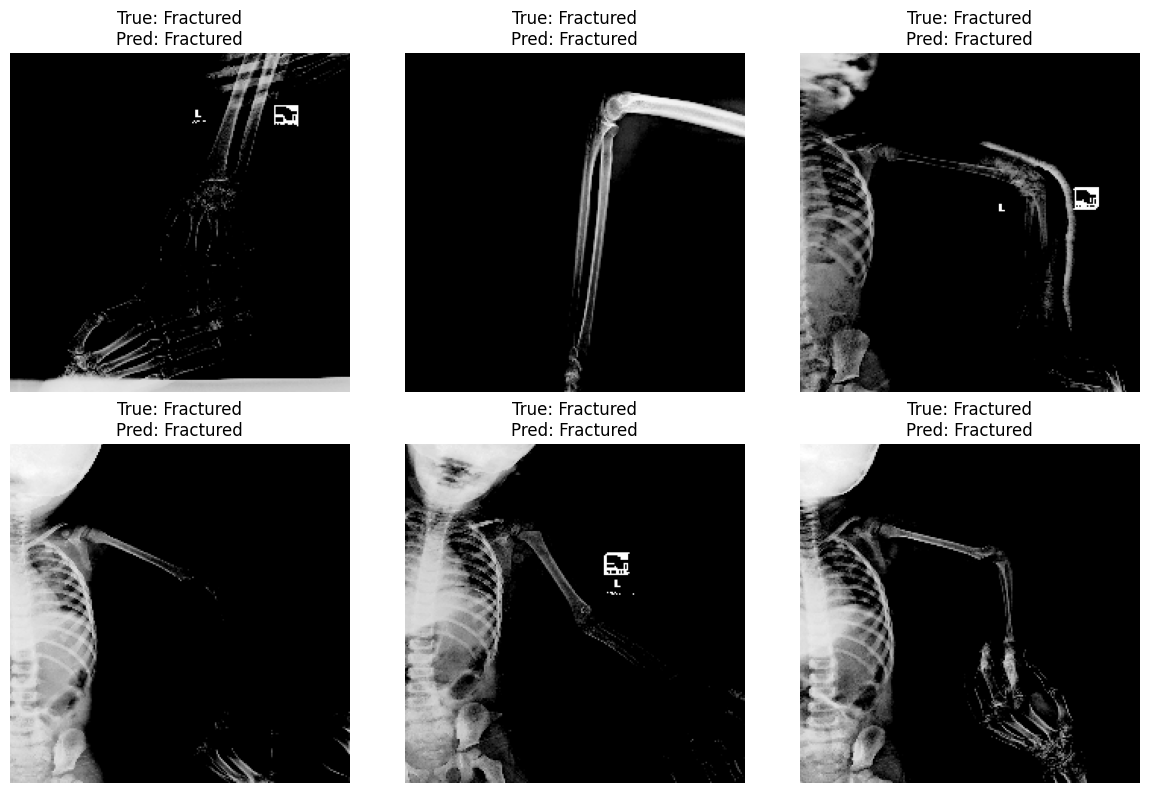

In [ ]:
# =============================
# Step 1: Imports and Cleanup
# =============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import glob

# Allow loading of corrupted/truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =============================
# Step 3: Define Paths
# =============================
fractured_path = '/content/drive/MyDrive/FracAtlas/images/Fractured'
non_fractured_path = '/content/drive/MyDrive/FracAtlas/images/Non_fractured'
root_path = '/content/drive/MyDrive/FracAtlas/images'

# =============================
# Step 4: Clean Corrupted Images
# =============================
print("Cleaning corrupted images...")
for folder in [fractured_path, non_fractured_path]:
    for img_path in glob.glob(folder + '/*'):
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image removed: {img_path}")
            os.remove(img_path)
print("Cleanup complete.")

# =============================
# Step 5: Image Data Generators
# =============================
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# =============================
# Step 6: MobileNetV2 Model
# =============================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# =============================
# Step 7: Train Model
# =============================
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# =============================
# Step 8: Accuracy/Loss Plots
# =============================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# =============================
# Step 9: Confusion Matrix + Report
# =============================
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.round(preds).astype(int).flatten()
y_true = val_generator.classes

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Fractured', 'Non_fractured']))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fractured', 'Non_fractured'],
            yticklabels=['Fractured', 'Non_fractured'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# =============================
# Step 10: Sample Predictions
# =============================
class_names = ['Fractured', 'Non_fractured']
val_generator.reset()
images, labels = next(val_generator)

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    pred_label = model.predict(np.expand_dims(images[i], axis=0))[0][0]
    pred_class = class_names[int(round(pred_label))]
    true_class = class_names[int(labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    img = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2BGR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)


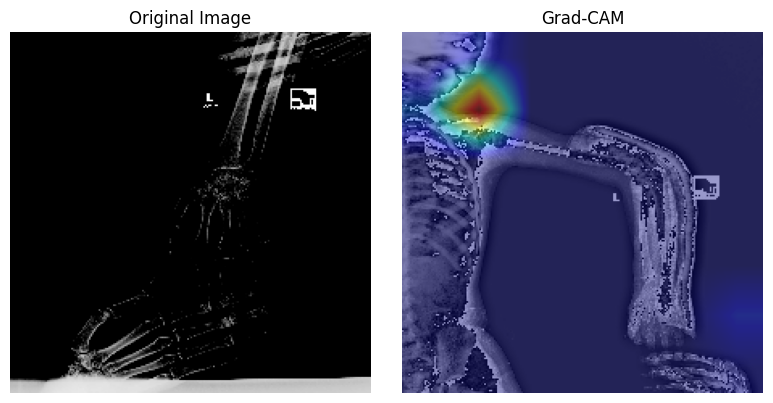

In [ ]:
# Reset and get a sample from validation generator
val_generator.reset()
sample_img, label = next(val_generator)
img_tensor = np.expand_dims(sample_img[0], axis=0)

# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name='Conv_1')
cam_image = superimpose_heatmap(sample_img[2], heatmap)

# Display
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_img[2])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cam_image)
plt.axis("off")
plt.tight_layout()
plt.show()


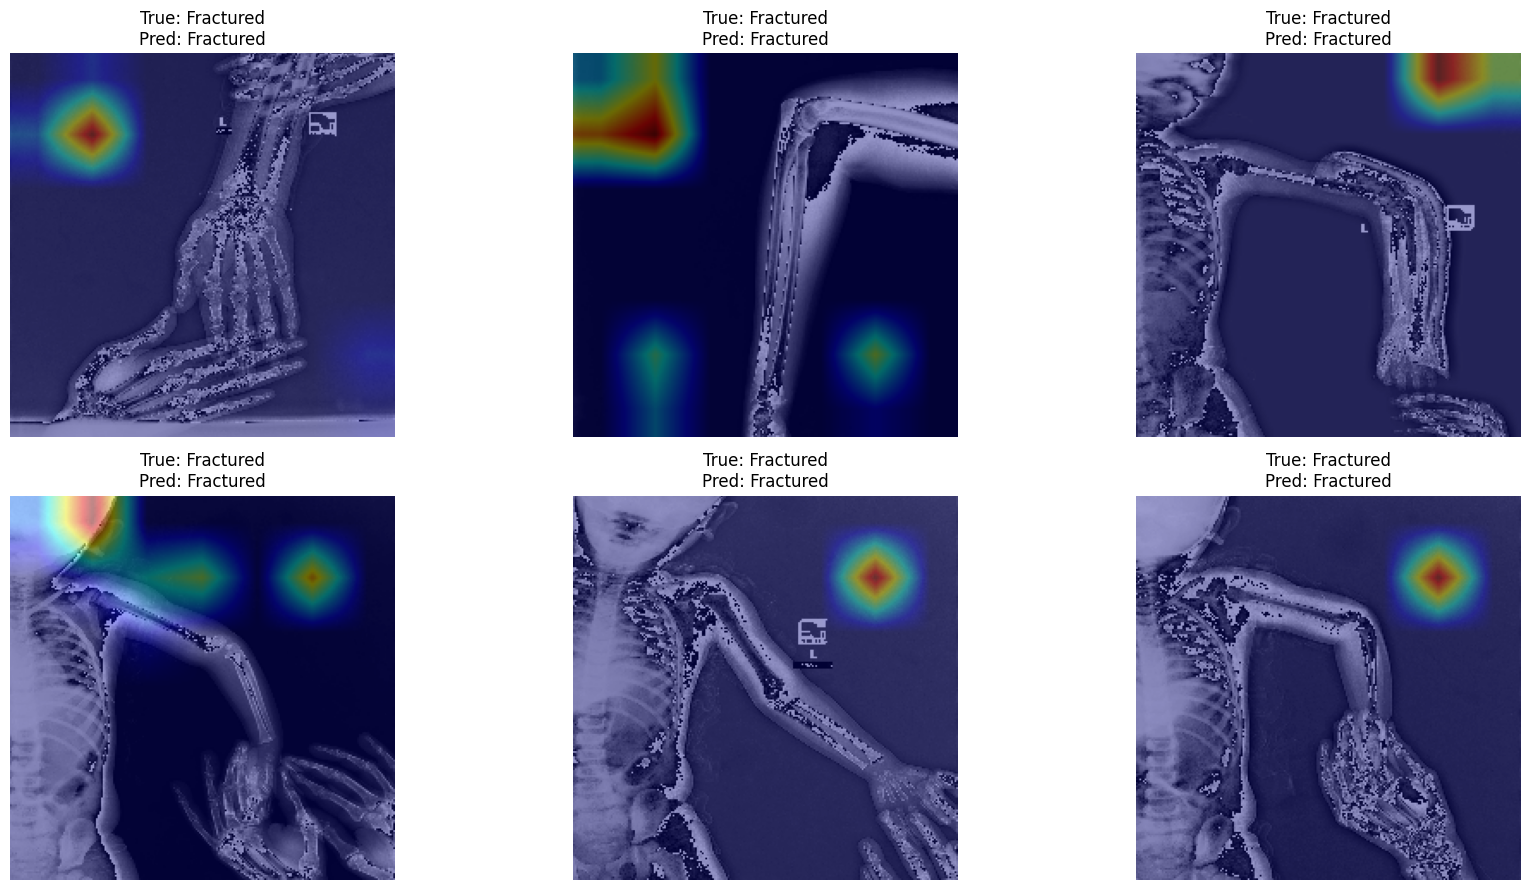

In [ ]:
# Class names
class_names = ['Fractured', 'Non_fractured']

# Number of samples to visualize
num_images = 6

# Reset validation generator
val_generator.reset()
images, labels = next(val_generator)

plt.figure(figsize=(18, 9))
for i in range(num_images):
    img = images[i]
    true_label = int(labels[i])
    img_tensor = np.expand_dims(img, axis=0)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name='Conv_1')
    cam_image = superimpose_heatmap(img, heatmap)

    # Predict
    pred_prob = model.predict(img_tensor, verbose=0)[0][0]
    pred_label = int(round(pred_prob))

    # Plot with prediction and ground truth
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(cam_image)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
for layer in model.layers:
    print(layer.name)


input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

In [ ]:
# Assuming model is your trained MobileNetV2
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer("Conv_1").output, model.output]
)


In [ ]:
def get_gradcam_heatmap(img_array, model, layer_name='Conv_1'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, 0]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


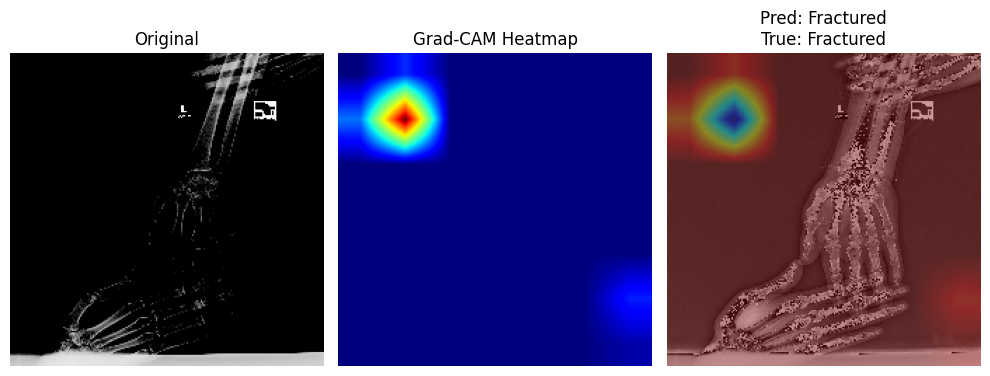

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


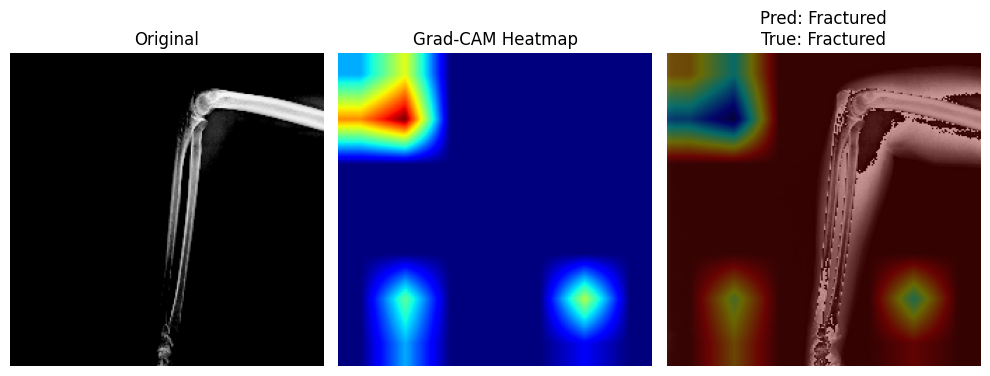

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


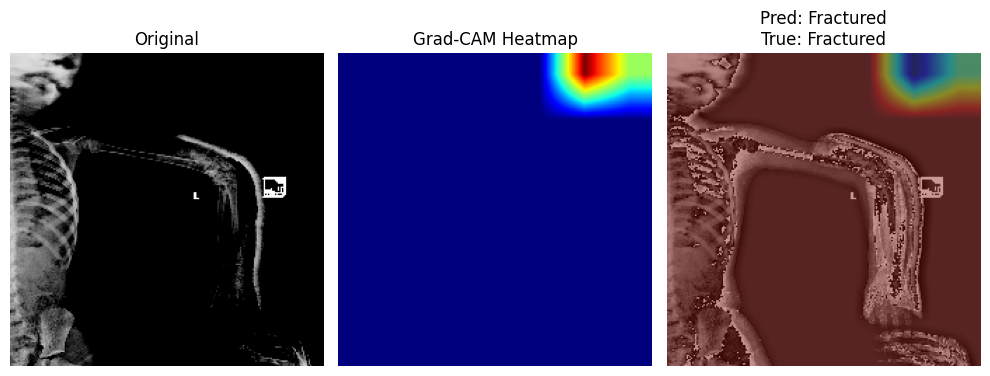

In [ ]:
import cv2

val_generator.reset()
images, labels = next(val_generator)

for i in range(3):  # Show 3 Grad-CAMs
    img = images[i]
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)[0][0]
    pred_class = int(round(prediction))
    true_class = int(labels[i])

    heatmap = get_gradcam_heatmap(img_array, model, layer_name='Conv_1')

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(np.uint8(img * 255), 0.6, heatmap_color, 0.4, 0)

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
